In [41]:
from itertools import product

import numpy as np
import pandas as pd
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from doe_modules.preferences import harmonic_mean
from doe_modules.preferences import kwarg_savefig, outputdir, harmonic_mean
from doe_modules.ml import plot_pr, plot_roc
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression

from doe_modules.simulation.esm9_metrics import cai

In [42]:
edges = np.load(f"{outputdir}/esm_test9_edges.npy")

df = pd.read_feather(
    f"{outputdir}/esm_test9.feather"
).assign(
    cai=pd.DataFrame({
        "cai": map(cai, edges),
    })
).assign(
    arithmetic=df.iloc[:, 4:7].mean(axis=1)
).assign(
    geometric=df.iloc[:, 4:7].apply(gmean, axis=1)
)

df = df.assign(
    better_with_cloo=df.cloo >= df.pb
)

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
import seaborn as sns

NameError: name 'y_te' is not defined

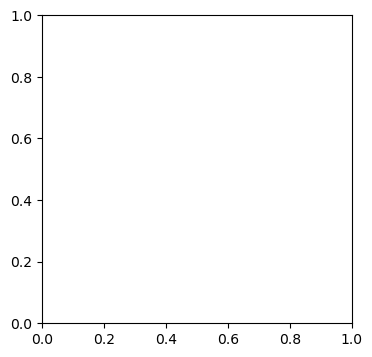

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    confusion_matrix(y_te, lr.predict(x_te.values.reshape(-1, 1))), 
    square=True, annot=True, fmt="", cmap="Blues",
    cbar_kws={"label": "sample counts", "shrink": .8}
)

ax.set_xticklabels(["No", "Yes"])
ax.set_yticklabels(["No", "Yes"])
ax.set(xlabel="predicted label", ylabel="true label", title="Test dataset");

# if conf.savefig:
#     fig.savefig(f"{conf.out}/confusion_matrix{conf.suffix}", **kwarg_savefig)

In [43]:
def cai_performance(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return np.vectorize(lambda t: metric(data.cloo < data.pb, data.cai <= t))(xrange)

def cai_performance_plot(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return (xrange, cai_performance(data, metric, xrange))

def argmax_cai(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    y = cai_performance(data, metric, xrange)
    argmax = np.argmax(y)
    return (xrange[argmax], y[argmax])

def cai_performance(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return np.vectorize(lambda t: metric(data.loc[:, ""] == "PB", data.cai <= t))(xrange)

def cai_performance_plot(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return (xrange, cai_performance(data, metric, xrange))

def argmax_cai(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    y = cai_performance(data, metric, xrange)
    argmax = np.argmax(y)
    return (xrange[argmax], y[argmax])

In [44]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

In [45]:
specificity_score(df.cloo < df.pb, df.cai <= .5)

0.11961384506710619

In [46]:
confusion_matrix(df.cloo < df.pb, df.cai <= .5)

array([[ 508, 3739],
       [ 203, 5550]])

In [47]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score

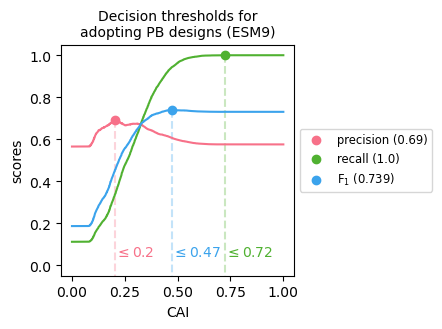

In [48]:
import warnings
warnings.simplefilter('ignore')

fig, ax = plt.subplots(figsize=(3, 3))

metrics = {
    # "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    # "specificity": specificity_score,
    "F$_1$": f1_score,
    # "AUROC": roc_auc_score,
    # "AP": average_precision_score,
}

argmax_recorder = {}

cmap = sns.color_palette("husl", len(metrics))

for  i, (k, metric) in enumerate(metrics.items()):
    x, y = cai_performance_plot(df, metric)
    ax.plot(x, y, color=cmap[i])
    idx = np.argmax(y)
    argmax_max = (x[idx], y[idx])
    ax.scatter(
        *argmax_max, 
        label=f"{k} ({argmax_max[1].round(3)})",
        color=cmap[i]
    )
    ax.vlines(*argmax_max, -0.05, color=cmap[i], linestyle="--", zorder=-100, alpha=.3)
    ax.text(argmax_max[0], .03, "$\leq$" + f"{argmax_max[0].round(2)}", color=cmap[i], ha="left", va="bottom")
    
    argmax_recorder = {**argmax_recorder, k: argmax_max[0]}

ax.set_xlim(-.05, 1.05)
ax.set_ylim(-.05, 1.05)

ax.legend(loc="center left", bbox_to_anchor=(1, .5), fontsize="small")

ax.set_title("Decision thresholds for\nadopting PB designs (ESM9)", size="medium")
ax.set(xlabel="CAI", ylabel="scores")

fig.savefig(f"{outputdir}/decision_thresh_test9", **kwarg_savefig)

In [49]:
df

,cloo,pb,v,,edge_coverage,pathway_sparsity,max_positive_edge_density,cai,arithmetic,geometric,better_with_cloo
0,0.000000,0.121951,0,neither,0.777778,0.777778,0.318182,0.336000,0.624579,0.577381,False
1,0.307692,0.415584,0,neither,0.722222,0.777778,0.086957,0.172566,0.528986,0.365547,False
2,0.228571,0.366197,0,neither,0.666667,0.555556,0.416667,0.487805,0.546296,0.536383,False
3,0.217391,0.000000,0,neither,0.638889,0.222222,0.000000,0.000000,0.287037,0.000000,True
4,0.210526,0.357143,0,neither,0.611111,0.666667,0.454545,0.438830,0.577441,0.569992,False
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.557377,0,neither,0.666667,0.444444,0.000000,0.000000,0.370370,0.000000,False
9996,0.800000,0.000000,1,C+LOO,0.777778,0.555556,0.535714,0.555311,0.623016,0.614005,True
9997,0.571429,0.000000,0,neither,0.527778,0.888889,0.642857,0.240958,0.686508,0.670612,True
9998,0.000000,0.000000,0,neither,0.638889,0.888889,0.000000,0.000000,0.509259,0.000000,True


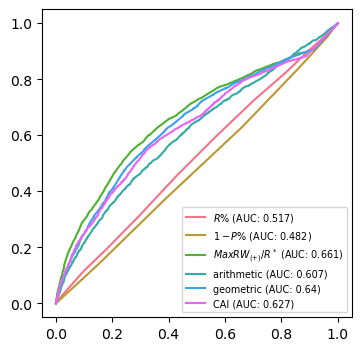

In [50]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.edge_coverage, df.pathway_sparsity, df.max_positive_edge_density,
    df.arithmetic, df.geometric, df.cai
]

names = [
    "$R\%$", "$1-P\%$", "$MaxRW_{(+)}/R^*$", "arithmetic", "geometric", "CAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_cloo, y)[:2], 
        label=names[i] + f" (AUC: {roc_auc_score(df.better_with_cloo, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

In [51]:
from sklearn.metrics import precision_recall_curve

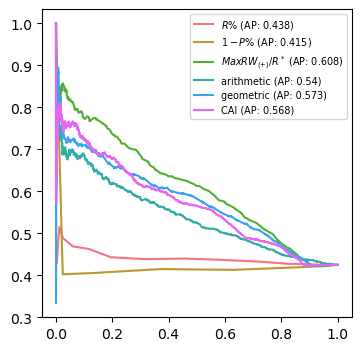

In [52]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.edge_coverage, df.pathway_sparsity, df.max_positive_edge_density,
    df.arithmetic, df.geometric, df.cai
]

names = [
    "$R\%$", "$1-P\%$", "$MaxRW_{(+)}/R^*$", "arithmetic", "geometric", "CAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_cloo, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_cloo, y).round(3)})", 
        c=cmap[i]
    )

ax.plot(np.linspace(0, 1, 10), np.linspace(1, 1, 10), c=".7", alpha=0)

ax.legend(fontsize="x-small")

In [12]:
from doe_modules.simulation import Sim1, Circuit, Sparse

In [13]:
# model phi
cai_phi = cai(np.array([
    1, 1, 0, 0, 0, 1, 1, 0, -1,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 1, 0, 0,
    -1, 0, 0, 0, 0,
    0, -1, 0, 0,
    -1, 0, 0,
    0, 0,
    1
]))

In [14]:
# model psi
cai_psi = cai(np.array([
    1, -1, 0, 0, 0, 0, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, -1, 1, -1, 0, 0,
    1, -1, 1, 0, 0,
    1, -1, 0, 0,
    1, 0, 0,
    -1, 0,
    1
]))

In [15]:
# model lambda
cai_lambda = cai(np.array([
    1, -1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    1, -1, 1, 0, 0,
    0, -1, 0, 0,
    1, 0, 0,
    -1, 1,
    0
]))

In [16]:
argmax_recorder

{'precision': 0.20400000000000001,
 'recall': 0.725,
 'F$_1$': 0.47200000000000003}

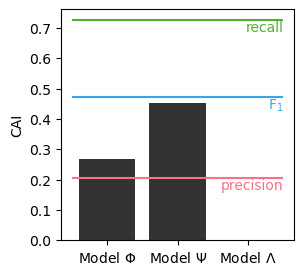

In [17]:
fig, ax= plt.subplots(figsize=(3, 3))

sns.barplot(
    data=pd.DataFrame({
        "": ["Model $\Phi$", "Model $\Psi$", "Model $\Lambda$"],
        "CAI": [cai_phi, cai_psi, cai_lambda]
    }),
    x="", y="CAI", ax=ax, color=".2"
)

xlim = ax.get_xlim()

for i, (k, v) in enumerate(argmax_recorder.items()):
    c = sns.color_palette("husl", len(argmax_recorder))
    ax.hlines(v, *xlim, color=c[i], label=k)
    ax.text(xlim[1], v, k, ha="right", va="top", color=c[i])